In [127]:
import pyhf
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner
import scipy.stats
%matplotlib inline

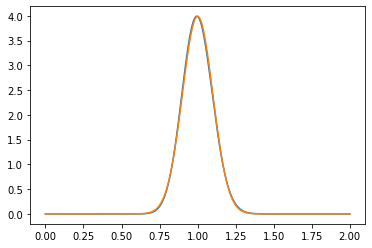

In [135]:
class TransformedDistribution(object):
    def __init__(self,base, jacobian, inverse, forward):
        self.base = base
        self.jacobian = jacobian
        self.inverse  = inverse
        self.forward  = forward
    
    def sample(self,*args,**kwargs):
        base_sample = self.base.sample(*args,**kwargs)
        return self.forward(base_sample)
        
    def log_prob(self,data):
        base_data = self.inverse(data)
        jacobian = self.jacobian(data)
        return self.base.log_prob(base_data) + pyhf.tensorlib.log(self.jacobian(data))
        
factor = 100
base = pyhf.probability.Poisson(pyhf.tensorlib.astensor(factor))
t = TransformedDistribution(
    base,
    jacobian = lambda y: factor,
    inverse  = lambda x: factor*x,
    forward  = lambda y: y/factor,
)
samples = t.sample((1000,)).ravel()
x = np.linspace(0/100,200/100,1001)
y = np.exp(t.log_prob(x))
y2 = scipy.stats.norm(1,0.1).pdf(x)
plt.plot(x,y)
plt.plot(x,y2)

In [138]:
class EmceeWrapper(object):
    def __init__(self,model):
        self.model = model

    def _make_poisson_prior(self):
        factor = self.model.constraint_model.constraints_poisson.batched_factors
        base   = pyhf.probability.Poisson(pyhf.tensorlib.astensor(factor))
        prob   = TransformedDistribution(
            base,
            jacobian = lambda y: factor,
            inverse  = lambda x: factor*x,
            forward  = lambda y: y/factor,
        )
        return prob

    def prior(self,pars):
        #bounds checking is here
        mu    = pars[...,0]
        gamma = pars[...,1]
        prob   = self._make_poisson_prior()
        return np.where(
            mu<0,-np.inf,prob.log_prob(gamma)
        )

    def lhood(self,pars,data):
         return self.model.main_model.logpdf(
            np.asarray(data),
            np.asarray(pars)
        )

    def lhood_times_prior(self,pars,x):
        return self.lhood(pars,x) + self.prior(pars)

In [139]:
w = EmceeWrapper(
    pyhf.simplemodels.hepdata_like([10],[50],[7])
)

p0 = 1+np.random.rand(4,2)
sampler = emcee.EnsembleSampler(4, 2, w.lhood_times_prior, args=[65])
results = sampler.run_mcmc(p0, 10000)
flat_samples = sampler.get_chain(discard=500, flat=True)

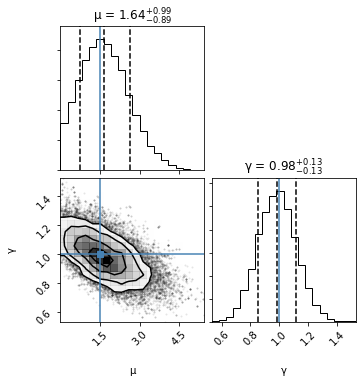

In [140]:
figure = corner.corner(flat_samples, labels = ['µ','γ'], truths = [1.5,1], quantiles=[0.16, 0.5, 0.84],show_titles=True)

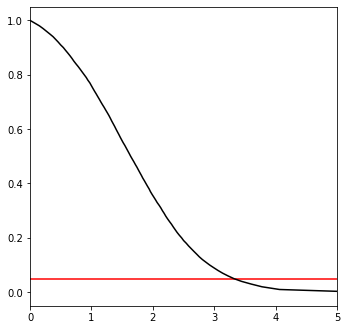

In [141]:
x = np.linspace(0,1,101)
y = [
    np.percentile(flat_samples[:,0],100*(1-xx)) for xx in x
]
plt.plot(y,x, label = 'hello', c = 'k')
plt.xlim(0,5)
plt.hlines(0.05,0,5, colors = 'r')
plt.gcf().set_size_inches(5.5,5.5)